<a href="https://colab.research.google.com/github/vbttchr/vbttchr/blob/main/Copy_of_05_classical_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5

In the past exercises, you have learned the essentials of python, cheminformatics as well as data curation and molecule representation. These steps are crucial for our first exercise about machine learning (ML). In particular, this exercise will focus on multivariate linear regression models, that are widely popular in the digital chemistry field due to their simplicity and interpretability. You will build a machine learning model for the prediction of rate constants of amide coupling reactions - further, you will use the descriptors that you calculated in 🔗Exercise 4.

## Tutorial

But first, we will look at a different dataset to explain the concept of multivariate linear regression. The dataset come from a [paper from Ravasco et al.](https://pubs.acs.org/doi/10.1021/jacs.9b11948) where they predict the activation energies for Diels-Alder reactions. You have already seen this dataset in 🔗Lecture 3 Part 2, where you assessed it according to the FAIR criteria. You found that the data is a table in a pdf file - the teaching team created a csv file for you to work on.

We start by importing the relevant libraries for this exercise and downloading the dataset.

In [ ]:
!wget https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/ied_da.csv

--2024-03-22 10:46:19--  https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/ied_da.csv
Resolving gitlab.ethz.ch (gitlab.ethz.ch)... 129.132.202.219
Connecting to gitlab.ethz.ch (gitlab.ethz.ch)|129.132.202.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110896 (108K) [text/plain]
Saving to: ‘ied_da.csv’

ied_da.csv          100%[===================>] 108.30K   256KB/s    in 0.4s    

2024-03-22 10:46:21 (256 KB/s) - ‘ied_da.csv’ saved [110896/110896]



In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np

Read in the csv to a pandas DataFrame and inspect it. In this case, we manually curated it already for you such that we can go straight to the machine learning. Even though the dataset is curated, we still need to bring it into a form so that we can use it as an input for our ML functions. For this, create a DataFrame `X` (our input) that contains only the columns with molecular descriptors. Also, create a Pandas Series `y` that consists of one column, the target property that we want to predict (activation energies in our case).

In [ ]:
# TODO: Read in the csv
data = pd.read_csv('ied_da.csv')
data.columns

Index(['Dienophile', 'Diene', 'Solvent', 'T (°C)', 'Measured k2 (M-1s-1)',
       'Reference (DOI)', 'T(K)', 'logk', 'activation_energy', 'dCC_x', 'dCN',
       'LL', 'SL', 'Φ', 'Ψ', 'ν1', 'NBOA', 'α1', 'α2', 'dCC_y', 'B11', 'B51',
       'S2', 'B53', 'B14', 'B1H', 'HOMO', 'Λ', 'ε'],
      dtype='object')

In [ ]:
# TODO: Create two DataFrames for dataset (X) and target (y)
X = pd.DataFrame(data,
                 columns = ['dCC_x', 'dCN','LL', 'SL', 'Φ', 'Ψ', 'ν1', 'NBOA', 'α1', 'α2', 'dCC_y', 'B11', 'B51',
                'S2', 'B53', 'B14', 'B1H', 'HOMO', 'Λ', 'ε'])

y = data['activation_energy']
data

,Dienophile,Diene,Solvent,T (°C),Measured k2 (M-1s-1),Reference (DOI),T(K),logk,activation_energy,dCC_x,...,dCC_y,B11,B51,S2,B53,B14,B1H,HOMO,Λ,ε
0,yne-02,dTz-32,MeOH/water (1:1),25,2670.0000,10.1021/ja302832g,298.15,7.889834,12.778562,2.551,...,1.208,2.0047,8.2061,100.6108,7.1838,2.0047,2.0319,-7.8614,-0.202,55.57
1,yne-02,dTz-31,MeOH/water (1:1),25,1250.0000,10.1021/ja302832g,298.15,7.130899,13.228219,2.549,...,1.208,2.0047,8.2061,100.6108,7.1838,2.0047,2.0319,-7.8614,-0.202,55.57
2,yne-02,dTz-03,MeOH/water (1:1),25,437.0000,10.1021/ja302832g,298.15,6.079933,13.850900,2.559,...,1.208,2.0047,8.2061,100.6108,7.1838,2.0047,2.0319,-7.8614,-0.202,55.57
3,yne-02,dTz-25,MeOH/water (1:1),25,80.0000,10.1021/ja302832g,298.15,4.382027,14.856885,2.561,...,1.208,2.0047,8.2061,100.6108,7.1838,2.0047,2.0319,-7.8614,-0.202,55.57
4,Norb-04,dTz-32,MeOH/water (1:1),25,5.0000,10.1021/ja302832g,298.15,1.609438,16.499602,2.551,...,1.337,2.1473,6.1427,3.0865,1.1700,5.6265,5.6265,-7.8201,0.414,55.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,ene-12,mTz-05,water/DMSO(12%),25,0.0527,10.1002/ejoc.201800094,298.15,-2.943140,19.196935,2.550,...,1.334,1.9586,3.7903,3.0769,1.1700,1.1700,1.9586,-7.2756,-0.193,74.76
463,cEne-01,mTz-05,water/DMSO(12%),37,1.2100,10.1002/ejoc.201800094,310.15,0.190620,18.062463,2.550,...,1.340,3.2651,10.2517,159.6949,1.1700,1.1700,3.2651,-7.4908,1.516,74.76
464,cEne-01,mTz-05,water/DMSO(12%),25,0.6880,10.1002/ejoc.201800094,298.15,-0.373966,17.674739,2.550,...,1.340,3.2651,10.2517,159.6949,1.1700,1.1700,3.2651,-7.4908,1.516,74.76
465,cEne-02,mTz-05,water/DMSO(12%),37,1.3200,10.1002/ejoc.201800094,310.15,0.277632,18.008835,2.550,...,1.340,3.2608,11.3535,139.1461,1.1700,1.1700,3.2608,-7.4903,-1.596,74.76


In this exercise, we start with linear regression, a method you have seen in 🔗Lecture 5, as it is a simple and interpretable.

In a ML campaign, we ideally want to develop a model that learns patterns from the training data to make true and general predictions for a vast amount of other data. In order to obtain an estimate for the generalisation of the model to unseen data, a part of the dataset should be left apart, forming a testing set. After chosing a model, this model should be tested on this unseen data to assess its accuracy (will be further explained in 🔗Lecture 6).

However, due to the small size of the dataset in this exercise, we will use here the whole dataset to train and select the model.

First, we will perform some exploratory data analysis (EDA), where we want to inspect the distribution of the molecular features and the target property (note that if a testing set was defined, this data should not be included in the EDA). For this, plot a histogram of the activation energy as well as a correlation matrix for the molecular features.

(array([ 1.,  2.,  4., 12., 14., 15., 20., 18., 47., 56., 64., 61.]),
 array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 12 artists>)

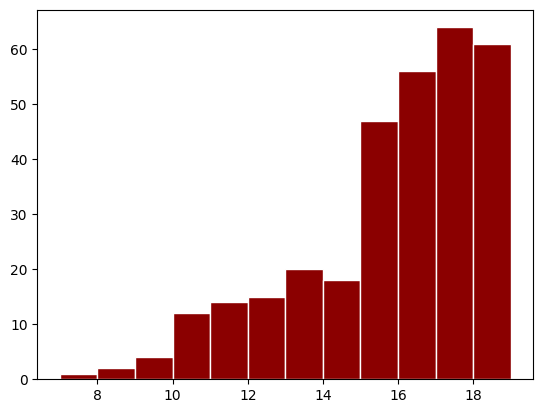

In [ ]:
# TODO: Plot histogram of distribution of activation energies
plt.hist(y,
         bins=list(range(7,20,1)),
         color='darkred',
         edgecolor='white',
         linewidth=1)

,dCC_x,dCN,LL,SL,Φ,Ψ,ν1,NBOA,α1,α2,dCC_y,B11,B51,S2,B53,B14,B1H,HOMO,Λ,ε
dCC_x,1.000000,-0.087025,0.266348,0.188259,0.818485,0.171387,-0.420909,0.210521,0.042043,-0.228765,-0.156628,-0.011113,0.339258,-0.040900,0.498810,-0.021678,-0.026923,-0.117624,0.291432,0.322781
dCN,-0.087025,1.000000,0.479402,0.460281,0.277305,0.198393,0.283604,-0.167608,-0.257637,0.235518,0.277169,-0.018728,0.040588,-0.165691,0.105154,-0.011657,0.046242,-0.001239,0.235333,0.240602
LL,0.266348,0.479402,1.000000,0.974335,0.444956,0.234069,-0.207803,0.044396,-0.037323,-0.067393,-0.024444,-0.120938,-0.022574,-0.199987,0.225488,0.077873,-0.042490,-0.077227,0.146356,0.069929
SL,0.188259,0.460281,0.974335,1.000000,0.352309,0.165838,-0.192176,0.037376,-0.035922,-0.056447,-0.019960,-0.160363,-0.080973,-0.219422,0.185754,0.062786,-0.086141,-0.054649,0.121917,-0.030905
Φ,0.818485,0.277305,0.444956,0.352309,1.000000,0.252015,-0.304162,0.150664,-0.025247,-0.140574,-0.054834,0.028379,0.339658,-0.077048,0.495635,0.000259,0.052293,-0.128554,0.365533,0.456735
Ψ,0.171387,0.198393,0.234069,0.165838,0.252015,1.000000,0.000226,0.019565,0.034701,-0.031458,-0.022301,0.095381,0.117940,0.066531,0.029778,0.010849,0.084361,-0.110604,-0.005196,0.213654
ν1,-0.420909,0.283604,-0.207803,-0.192176,-0.304162,0.000226,1.000000,-0.094502,-0.062979,0.121740,0.108293,0.052263,-0.044472,0.018816,-0.126129,0.001554,0.059814,0.028250,-0.040375,0.024401
NBOA,0.210521,-0.167608,0.044396,0.037376,0.150664,0.019565,-0.094502,1.000000,0.769844,-0.787402,-0.743052,0.114168,0.224282,0.311323,0.219677,0.128540,0.033309,-0.032246,-0.099124,-0.146873
α1,0.042043,-0.257637,-0.037323,-0.035922,-0.025247,0.034701,-0.062979,0.769844,1.000000,-0.892791,-0.895623,0.074534,0.008239,0.341439,-0.030038,0.151131,0.004447,-0.096405,-0.422402,-0.231808
α2,-0.228765,0.235518,-0.067393,-0.056447,-0.140574,-0.031458,0.121740,-0.787402,-0.892791,1.000000,0.984677,0.091871,-0.089421,-0.213019,-0.273588,-0.126491,0.153726,0.128887,0.252977,0.265885


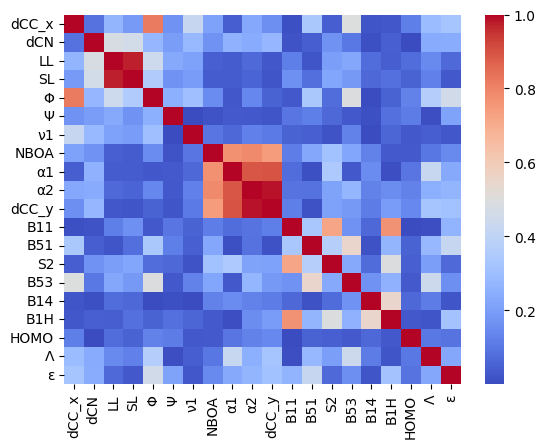

In [ ]:
# TODO: Plot correlation heatmap of features
# Hint: You can use a function from the Seaborn library for this
yframe = y.to_frame()
# yframe

# eda_data = pd.concat([x,yframe],axis=1)
# eda_data.set_index('activation_energy', inplace=True)
sns.heatmap(x.corr().abs(),
            cmap="coolwarm")
x.corr()

The correlation matrix provides an overview of the correlation between variables. Correlated variables are not a problem for prediction, but they might be for interpretation as a model could pick up either of the strongly correlated variables and one has to beware of this.

After this initial EDA, we are ready to develop our machine learning models. To try different models and select the best one, we need to split our dataset into a training set (used to train the models) and a validation set (used to assess the model's performance to compare them) (🔗Lecture 6).

Some important remarks on the splitting:
- The functions we use to split the data are the same to take appart a test set or a validation set, therefore they contain the word `test` even though what we have here is a "validation" and not a "test" set.
- There are some peculiarities when splitting data, but for this exercise we will use a random split that splits our shuffled data in 70% training and 30% validation data, taking the same percentages as [Ravasco et al](https://pubs.acs.org/doi/10.1021/jacs.9b11948).
- In order to obtain reproducible results, one needs to set an explicit random state (parameter which ensures that the random numbers given by the random number generator will be identical every time the code is run). In this exercise, let's fix `random_state=42` every time it is used.

Perform the split according to the above-mentioned criteria. If you need a starting point, look at the imported functions at the beginning of this notebook and try to look up the relevant ones.

In [ ]:
# TODO: Split the data into train and validation sets
X_train, X_val, y_train, y_val =  train_test_split(
                                    X, y, test_size=0.3, train_size=0.7, random_state=42)


Now, we want to use the scikit-learn library to build a pipeline that takes in our data and performs the desired transformations. In our case, we want the pipeline to consist of a Scaler (`StandardScaler` to be precise) and then a linear regression. The scaling of the variables X is a good practice in ML and also ensures interpretability: the coefficients in our linear regression correspond therefore to the importance of the variables for the prediction.

Our dataset has 20 descriptors and for a good generalisation, one has to be careful to not overfit. Thus, we will create a model that selects a defined number of the most important features - the `SequentialFeatureSelector` (SFS). We initiate a selector and fit it to the training data - the selector finds the n (in our case 8) most important descriptors. The selection is based on the $R^2$ score, which is default scoring for a linear regression model as you have seen in 🔗Lecture 5.

In [ ]:
# Select features
est = make_pipeline(StandardScaler(), LinearRegression())
selector = SFS(est, n_features_to_select=8)
selector.fit(X_train, y_train)
print(selector.get_feature_names_out())
selector

['dCC_x' 'dCN' 'SL' 'Φ' 'B53' 'HOMO' 'Λ' 'ε']


SequentialFeatureSelector(estimator=Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('linearregression',
                                                     LinearRegression())]),
                          n_features_to_select=8)

After we elucidated the features chosen by our selector, we need to transform our dataset such that only the important features are contained.

In [ ]:
# Select only the features that were chosen
X_small = selector.transform(X)
# TODO: Do the same for the training set X_small_train =
X_small_train = selector.transform(X_train)
# TODO: Do the same for the validation set X_small_val =
X_small_val = selector.transform(X_val)

Now that we have a transformed dataset, we can train our model. For this we again take our pipeline, that consists of scaler and regressor, and fit it to our training data. After the model is trained, we can use it to form predictions for both our train data and validation data. For visualisation, we can plot the predicted activation energies against the measured ones.

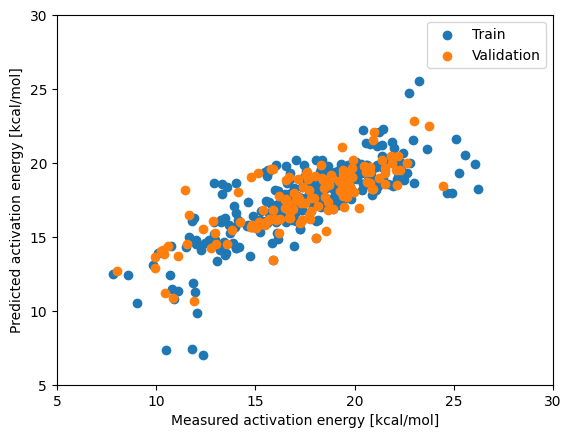

R2 train: 0.6034843953653313
R2 validation: 0.6233770395056849


In [ ]:
# Train model on the smaller feature space
est.fit(X_small_train, y_train)
y_train_pred = est.predict(X_small_train)
y_val_pred = est.predict(X_small_val)

# Plot
plt.scatter(y_train, y_train_pred, label="Train")
plt.scatter(y_val, y_val_pred, label="Validation")
plt.legend()
plt.xlabel("Measured activation energy [kcal/mol]")
plt.ylabel("Predicted activation energy [kcal/mol]")
plt.xlim(5, 30)
plt.ylim(5, 30)
plt.show()

# Calculate R^2 scores
print("R2 train:", est.score(X_small_train, y_train))
print("R2 validation:", est.score(X_small_val, y_val))

To have further assessment of the statistical performance of our model, we will perform cross validation, more precisely leave-one-out cross validation (LOOCV), where the validation set consists of only one datapoint and the training set of the rest. This is done iteratively for the entire dataset (more in 🔗Lecture 6).

In [ ]:
# Do Leave-One-Out cross validation
y_true, y_pred = [], []
for train_ix, val_ix in LeaveOneOut().split(X):
    est_ = make_pipeline(StandardScaler(), LinearRegression())
	# Split data
    X_train_, X_val_ = X_small[train_ix, :], X_small[val_ix, :]
    y_train_, y_val_ = y.iloc[train_ix], y.iloc[val_ix]
	# Fit model
    est_.fit(X_train_, y_train_)
	# Evaluate model
    yhat = est_.predict(X_val_)
	# Store
    y_true.append(y_val_.iloc[0])
    y_pred.append(yhat[0])

print("LOOCV Q2:", r2_score(y_true, y_pred))

LOOCV Q2: 0.5844335326264494


Using LOOCV, we already have a decent glimpse of the performance of our model. However, we are not only interested in predictive performance of our model, but also in the interpretability. For this aspect, we care about the features that were selected by the selector, as these features are used by the model to predict activation energies.
However, we can also assess the relative importance of the features - we can do this by plotting the values of the coefficients, where the descriptors with a larger coefficient are considered as more important.

In order to allow interpretability, it is essential to scale the features before training the model as we did at the beginning, which means that all features are on a similar scale and the coefficients are thus comparable. Also, as noted previously, one has to make sure to not include features that are strongly correlated with each others when training interpretable ML models.

The plot below give you an insight into the molecular features that are important for the reaction - you can interpret them in connection with the reaction mechanism with respect to their electronic / steric meaning to form a mechanistic hypothesis (but be careful that model intepretability is a tricky task, especially in the low data range, as we will see further down).

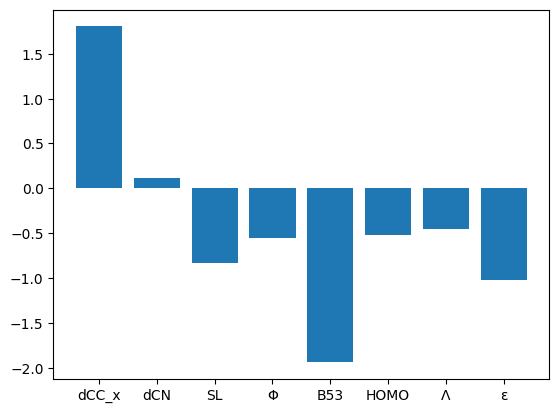

In [ ]:
# Print out the important features and the magnitude of their coefficient
coefs = est.named_steps["linearregression"].coef_
plt.bar(range(len(coefs)), coefs)
_ = plt.xticks(range(len(coefs)), selector.get_feature_names_out())

We can also plot the correlation matrix on the smaller subset of features. You see that most of the selected features have a low correlation, but the C-C distance `dCC_x` and the dihedral angle `Φ` are still highly correlated. That is because the selection is based on the prediction performance and not the features correlation, which has to be kept in mind when trying to intepret the model.

<Axes: >

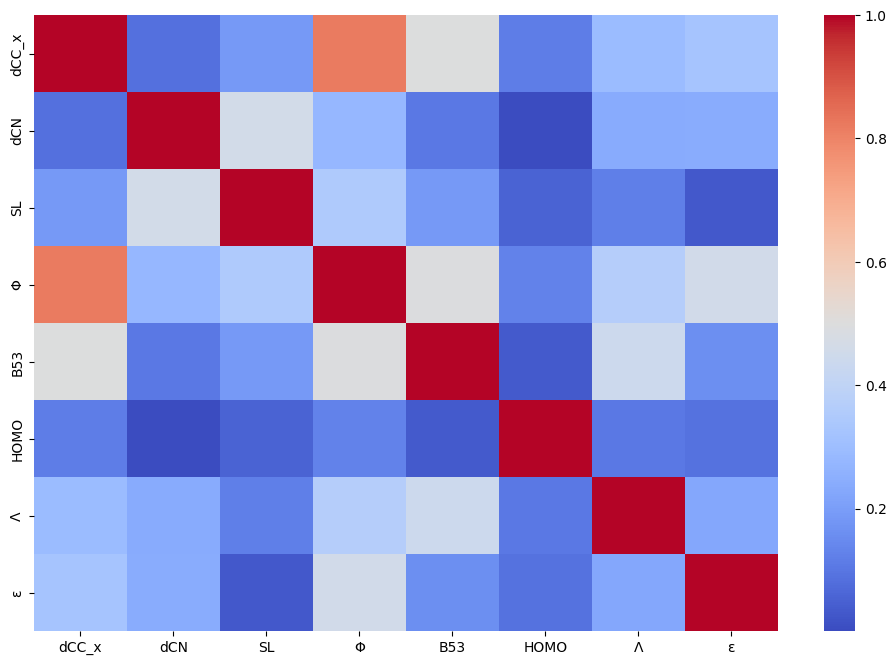

In [ ]:
# Plot correlation matrix of selected features
X_small_df = X[selector.get_feature_names_out()]
plt.figure(figsize=(12, 8))
sns.heatmap(X_small_df.corr().abs(), cmap="coolwarm")

## Task

Now that we know how to set up a ML pipeline, use a sequential feature selector to select features, train linear regression models, perform leave-one-out cross-validation and analyse the regression coefficients, we can put the new concepts to use. For this, we will again consider the amide coupling reaction between carboxylic acids and primary amines, for which we already have calculated descriptors in 🔗Exercise 4. We will analyse how to select the number of features, their stability and also interpret them.

For your convenience, the teaching team has collected even more descriptors! These descriptors stem from the original publication by [Haas et al.](https://doi.org/10.1073/pnas.2118451119). In this exercise, we will compare our results to theirs (for this, use a validation set size of 0.3).

We will start by downloading a csv file that contains information on the reactions: an ID for each carboxylic acids and amines participating in the reaction (`AcI` and `NI`, with `I` being a number corresponding to the row index in the acids and amines datasets respectively), and the measured rate constant.

We also download the acids and amines datasets, containing the descriptors calculated on each molecule.

In [ ]:
# Import reaction data
!wget https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_amide_coupling.csv

--2024-03-22 14:06:38--  https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_amide_coupling.csv
Resolving gitlab.ethz.ch (gitlab.ethz.ch)... 129.132.202.219
Connecting to gitlab.ethz.ch (gitlab.ethz.ch)|129.132.202.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1040 (1.0K) [text/plain]
Saving to: ‘Ex5_dataset_amide_coupling.csv’

Ex5_dataset_amide_c 100%[===================>]   1.02K  --.-KB/s    in 0s      

2024-03-22 14:06:39 (601 MB/s) - ‘Ex5_dataset_amide_coupling.csv’ saved [1040/1040]



In [ ]:
# Import calculated features
!wget https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_acids.csv
!wget https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_amines.csv

--2024-03-22 14:06:43--  https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_acids.csv
Resolving gitlab.ethz.ch (gitlab.ethz.ch)... 129.132.202.219
Connecting to gitlab.ethz.ch (gitlab.ethz.ch)|129.132.202.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7562 (7.4K) [text/plain]
Saving to: ‘Ex5_dataset_acids.csv’

Ex5_dataset_acids.c 100%[===================>]   7.38K  --.-KB/s    in 0s      

2024-03-22 14:06:43 (67.7 MB/s) - ‘Ex5_dataset_acids.csv’ saved [7562/7562]

--2024-03-22 14:06:43--  https://gitlab.ethz.ch/schmiste/digital_chemistry_fs24/-/raw/main/Exercise5/Ex5_dataset_amines.csv
Resolving gitlab.ethz.ch (gitlab.ethz.ch)... 129.132.202.219
Connecting to gitlab.ethz.ch (gitlab.ethz.ch)|129.132.202.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7600 (7.4K) [text/plain]
Saving to: ‘Ex5_dataset_amines.csv’

Ex5_dataset_amines. 100%[===================>]   7.42K  --.-KB/s    in 0s     

In [ ]:
# TODO: Load the reaction data, acids dataset and amines dataset as DataFrames
rxn_data = pd.read_csv('Ex5_dataset_amide_coupling.csv',index_col=0)
acids = pd.read_csv('Ex5_dataset_acids.csv',index_col=0)
amines = pd.read_csv('Ex5_dataset_amines.csv',index_col=0)
x = pd.concat([acids,amines],ignore_index=True)
rxn_data

,Acid,Amine,k
Amide Coupling,,,
Ac13-N1,Ac13,N1,0.0324
Ac16-N1,Ac16,N1,0.7690
Ac4-N2,Ac4,N2,0.7521
Ac5-N2b,Ac5,N2,0.0766
Ac17-N2,Ac17,N2,0.4886
Ac4-N3,Ac4,N3,0.3328
Ac8-N3,Ac8,N3,4.8788
Ac12-N3,Ac12,N3,5.9721
Ac17-N3,Ac17,N3,0.6173


The first thing to do is to create a DataFrame `X` which contains the acid and amine descriptors for each reaction. Furthermore, also create our target to predict `y`. Since the rate constants span multiple orders of magnitude, the target we will take will be the natural logarithm of the rate constant.

In [ ]:
# TODO: Create a column with the natural logarithm of the rate constant
y = np.log(rxn_data['k'])
# Extract indices for acids and amines based on their IDs in rxn_data
rxn_data['acid_row_index'] = rxn_data['Acid'].str.extract('(\d+)').astype(int) - 1
rxn_data['amine_row_index'] = rxn_data['Amine'].str.extract('(\d+)').astype(int) - 1

# Get lists of column names for descriptors
acid_descriptors = [col for col in acids.columns if col not in ['smiles', 'ensemble_crest'] and 'idx' not in col]
amine_descriptors = [col for col in amines.columns if col not in ['smiles', 'ensemble_crest'] and 'idx' not in col]
print(rxn_data['acid_row_index'])
# TODO: Merge the reaction data, acid descriptors and amine descriptors into one DataFrame, containing one row for each reaction
df_acid_descriptors = pd.DataFrame(acid_descriptors)
df_amine_descriptors = pd.DataFrame(amine_descriptors)
# Data_Frame = pd.concat([y,df_acid_descriptors,df_amine_descriptors],axis=1)

# TODO: Split the DataFrame into X (features) and y (target: ln(k))

Amide Coupling
Ac13-N1     12
Ac16-N1     15
Ac4-N2       3
Ac5-N2b      4
Ac17-N2     16
Ac4-N3       3
Ac8-N3       7
Ac12-N3     11
Ac17-N3     16
Ac6-N4       5
Ac15-N5     14
Ac17-N5     16
Ac1-N6       0
Ac5-N6       4
Ac8-N6       7
Ac9-N6       8
Ac12-N6     11
Ac17-N6     16
Ac3-N7       2
Ac4-N7       3
Ac2-N8       1
Ac19-N8     18
Ac9-N9       8
Ac21-N9     20
Ac1-N10      0
Ac11-N10    10
Ac10-N11     9
Ac20-N11    19
Ac22-N11    21
Ac1-N12      0
Ac18-N12    17
Ac2-N13      1
Ac8-N13b     7
Ac14-N13    13
Ac7-N14      6
Ac17-N14    16
Ac22-N14    21
Ac5-N15      4
Ac6-N15      5
Ac7-N15      6
Ac15-N15    14
Ac17-N15    16
Ac13-N16    12
Ac15-N16    14
Name: acid_row_index, dtype: int64


Now that we have created our dataset, you have to conduct some EDA. In the ML pipeline, the dataset should also be cleaned, but here the teaching team already took care of it.

In [ ]:
rxn_data

,Acid,Amine,k,acid_row_index,amine_row_index
Amide Coupling,,,,,
Ac13-N1,Ac13,N1,0.0324,12,0
Ac16-N1,Ac16,N1,0.7690,15,0
Ac4-N2,Ac4,N2,0.7521,3,1
Ac5-N2b,Ac5,N2,0.0766,4,1
Ac17-N2,Ac17,N2,0.4886,16,1
Ac4-N3,Ac4,N3,0.3328,3,2
Ac8-N3,Ac8,N3,4.8788,7,2
Ac12-N3,Ac12,N3,5.9721,11,2
Ac17-N3,Ac17,N3,0.6173,16,2


In [ ]:
# TODO: Perform some EDA
udo=2
alf = rxn_data.loc[rxn_data.index==udo,'acid_row_index']
print(rxn_data.index)

Index(['Ac13-N1', 'Ac16-N1', 'Ac4-N2', 'Ac5-N2b', 'Ac17-N2', 'Ac4-N3',
       'Ac8-N3', 'Ac12-N3', 'Ac17-N3', 'Ac6-N4', 'Ac15-N5', 'Ac17-N5',
       'Ac1-N6', 'Ac5-N6', 'Ac8-N6', 'Ac9-N6', 'Ac12-N6', 'Ac17-N6', 'Ac3-N7',
       'Ac4-N7', 'Ac2-N8', 'Ac19-N8', 'Ac9-N9', 'Ac21-N9', 'Ac1-N10',
       'Ac11-N10', 'Ac10-N11', 'Ac20-N11', 'Ac22-N11', 'Ac1-N12', 'Ac18-N12',
       'Ac2-N13', 'Ac8-N13b', 'Ac14-N13', 'Ac7-N14', 'Ac17-N14', 'Ac22-N14',
       'Ac5-N15', 'Ac6-N15', 'Ac7-N15', 'Ac15-N15', 'Ac17-N15', 'Ac13-N16',
       'Ac15-N16'],
      dtype='object', name='Amide Coupling')


In [ ]:
# adult_names = titanic.loc[acids_index == rxn_data['acid_row_index'], df_acid_descriptors]


# above = acids[acids.columns == 'acid_descriptors']
print(amloc.T)
testdf = pd.concat([acloc,amloc],axis=1,names=[acid_descriptors,amine_descriptors])

dummydf = pd.DataFrame()

for udo in len(rxn_data.index)
  ac_loc = acids.loc[acids.index == rxn_data.iloc[udo,'acid_row_index'], acid_descriptors]
  am_loc = amines.loc[amines.index == 0, amine_descriptors]

  dummydf = dummydf.concat([acloc,amloc],axis=1,names=[acid_descriptors,amine_descriptors])

                                               0
dipole_amine                            2.761553
E (HOMO)_amine                         -0.305387
E (LUMO)_amine                          0.003743
NBO-N1_amine                           -0.888752
NBO-H2_amine                            0.368689
NBO-H3_amine                            0.364646
NBO-C4_amine                           -0.214329
delta_NBO-H2-H3_amine                   0.004952
ave_NBO-H2-H3_amine                     0.366668
NMR-N1_amine                          239.056774
NMR-H2_amine                           30.721214
NMR-H3_amine                           31.404936
NMR-C4_amine                          142.839426
delta_NMR-H2-H3_amine                   0.924502
ave_NMR-H2-H3_amine                    31.063075
pyramidalization N1 (1st)_anion         0.772964
lone-pair-N1_anion                     -0.377147
angle-H2-N1-H3_amine                  107.159927
angle-C4-N1-H2_amine                  110.011925
angle-C4-N1-H3_amine

,dipole_acid,E (HOMO)_acid,E (LUMO)_acid,NBO-C1 C=O_acid,NBO-O2 C=O_acid,NBO-O3 O-H,NBO-C4_acid,NBO-H5 O-H_acid,NMR-C1 C=O_acid,NMR-O2 C=O_acid,...,Sterimol-L-N1-C4_amine,Sterimol-B1-N1-C4_amine,Sterimol-B5-N1-C4_amine,IR-freq-N-H_sym-stretch _amine,IR-int-N-H_sym-stretch _amine,IR-freq-N-H_asym-stretch_amine,IR-int-N-H_asym-stretch_amine,IR-freq-N-H_bend_amine,IR-int-N-H_bend_amine,Vbur-2.5A_amine
0,2.007054,-0.351506,0.000795,0.841832,-0.636284,-0.718098,-0.50237,0.495988,-6.767065,-147.546282,...,4.683214,1.741609,5.249353,3499.003928,0.876632,3577.986452,3.4743,1666.330071,29.497005,48.784901


 After that, we are ready to perform a linear regression. For this, we have to figure out how many descriptors we should use for our model.

Several factors have to be considered for this:

* you should have enough descriptors to obtain a decent model performance
* you should have little enough descriptors to avoid overfitting
* you should have little enough descriptors to allow for simple model interpretation

Find out how many descriptors are ideal for our fit taking into account the abovementioned criteria.

In [ ]:
# TODO: Determine the optimal number of descriptors
# Hint: Start by writing a function which evaluates the performance of the model for one given number of descriptors
#       and then call this function with several different numbers of descriptors to compare them
# Don't forget the random_state=42 to have results comparable with the solution

Once you decided on the ideal number of features for our modeling purposes, retrain the model with the right number of descriptors and analyse the importance of the coefficients. This allows you to make interpretation about the mechanism (see questions at the end of the exercise).

As explained at the beginning, we did not have enough data to set aside a testing set. However, a trick one can do in this case is to train the final model with a cross-validation performed with a different random split (e.g. `random_state=24`) to empirically recover a decent measure of the generalisation error.

In [ ]:
# TODO: Retrain the model with `random_state=24` for the train/validation split and analyse the importance of the coefficients

As a final step, we will test the rigorosity of the selected coefficients, as these depend on the training set on which the selector acts. To investigate further, we will use resampling to investigate the stability of the feature selection process.

Resampling methods simulate the effect of having another dataset drawn from the same underlying distribution as the dataset that we already have. The two most common techniques are cross-validation, which we already encountered, and bootstrapping. They are in fact closely related to each other. Bootstrapping can be seen as a trick were we exploit the following ideas:

1. We want another sample from the same distribution as the data we have
2. Because our data comes from that distribution, we can actually sample from it with replacement, pretending that it is that underlying distribution.

The deeper theory of bootstrapping is unfortunately beyond the scope of this session. The procedure is of course not perfect especially if our dataset is small, but it works well enough that it is a standard technique in statistics. Scikit-learn provides the `resample` function that does exactly this.

What we will do is simply to take ten bootstrap samples and carry out the same modeling procedure as above. For this, we will train a model N times (e.g. 10 times) - where we modify our dataset by bootstrapping. You can do this by including the line `X_, y_ = resample(X, y)` to get a new bootstrapped dataset `X_` and `y_`.
For the new dataset, train a new model, analyse its performance and save the chosen descriptors. Subsequently, plot a histogram that shows how often each descriptor has been chosen.

In [ ]:
# TODO: Perform multiple rounds of model training with a bootstrapped dataset each time and save the important descriptors

In [ ]:
# TODO: Plot a histogram for how many times the features have been chosen

## Answers to Questions

1. In the part where you had to pick a number of descriptors, how did you decide on which number to select?

2. What consequence would you expect if you change or remove the `random_state=42` parameter? Perform this experiment by running several times the code without this parameter, and comment on the results.

3. Below you can see the model equation that [Haas et al.](https://www.pnas.org/doi/full/10.1073/pnas.2118451119) derived (note that Haas et al. also used descriptors of intermediates in their modeling that we disregarded for simplicity). How do the features importance compare to yours (don't forget to take into account the stability test which you performed with boostrapping)? What can you conclude regarding the interpretability of the model?

![](https://drive.google.com/uc?export=view&id=1xbwd2L8NT36CE6UroLH7h4Zbi--g1w6f)
